<a href="https://colab.research.google.com/github/hyunku/Reservoir-Computing/blob/main/simpleESN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# simple ESN lower level coding

In [ ]:
# updating

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sys

# data = np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/MackeyGlass_t17.txt')

# trainlen = 7000
# future = 3000

# X_train = np.ones(trainlen)
# Y_train = data[:trainlen]
# X_test = np.ones(future)
# Y_test = data[trainlen:trainlen+future]

# print(X_train.shape)
# print(Y_train.shape)
# print(X_test.shape)
# print(Y_test.shape)

device = torch.device('cuda')
dtype = torch.float
torch.set_default_dtype(dtype)

if dtype == torch.double:
    data = np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/mg17.csv', delimiter=',', dtype=np.float64)
elif dtype == torch.float:
    data = np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/mg17.csv', delimiter=',', dtype=np.float32)

print(data.shape) # (10000,2)
X_data = data[:,[0]]
Y_data = data[:,[1]]
# X_data = torch.from_numpy(X_data).to(device)
# Y_data = torch.from_numpy(Y_data).to(device)

# X_train = X_data[:5000]
# Y_train = Y_data[:5000]
# X_test = X_data[5000:]
# Y_test = Y_data[5000:]

X_train = torch.FloatTensor(X_data[:5000])
Y_train = torch.FloatTensor(Y_data[:5000])
X_test = torch.FloatTensor(X_data[5000:])
Y_test = torch.FloatTensor(Y_data[5000:])


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# sys.exit()

# class TensorData(Dataset): # 전처리(np->tensor 등등 작업)
  
#     def __init__(self, x_data, y_data):
#         self.x_data = torch.FloatTensor(x_data) # float32
#         self.y_data = torch.FloatTensor(y_data)
#         self.len = self.y_data.shape[0]

#     def __getitem__(self, index):
#         return self.x_data[index], self.y_data[index] 

#     def __len__(self):
#         return self.len


# trainsets = TensorData(X_train, Y_train) # 전처리
# trainloader = torch.utils.data.DataLoader(trainsets, batch_size=10, shuffle=False) # 배치처리, 셔플유무

# testsets = TensorData(X_test, Y_test)
# testloader = torch.utils.data.DataLoader(testsets, batch_size=10, shuffle=False)


class ESN(torch.nn.Module):
    def __init__(self, input_size, reservoir_size, output_size): # 인풋노드수, reservoir뉴런수, 출력층뉴런수
        super(ESN, self).__init__()
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size

        # float32
        self.w_in = torch.rand(input_size, reservoir_size, requires_grad=False) # (인풋노드수, 은닉노드수)
        self.w_internal = torch.rand(reservoir_size, reservoir_size, requires_grad=False)
        self.w_readout = torch.rand(output_size, requires_grad=False)

    def _update(self, state, input_pattern, output_pattern): # reservoir 내부 뉴런 학습치 -> (1(이전데이터),res), (1(현재데이터),입력층 뉴런수)
        preactivation = (torch.matmul(self.w_internal, state) # (res,res) matmul (1,res) -> (1,res) -> (res,) 
                             + torch.matmul(self.w_in.T, input_pattern) # (res, 입력층 뉴런수) matmul (1, 입력층 뉴런수) -> (1,res) -> (res,)
                             + torch.matmul(self.w_readout.T, output_pattern))
        return torch.tanh(preactivation) # 다음 reservoir 뉴런 학습치는 이전 단계의 reservoir 학습치와 현시점 인풋 데이터의 합에 활성함수를 씌워준 것.
    
    def fit(self, x_tr, y_tr_teacher): # train set으로 readout 가중치 학습
      with torch.no_grad():
        states = torch.zeros(x_tr.shape[0], self.reservoir_size, requires_grad=False) # 학습 과정 중 학습될 reservoir뉴런의 학습치 행렬, 우선 초기값 설정(학습 데이터 수, res)
        for n in range(1, x_tr.shape[0]): # 학습 데이터 전체 돌면서
          # reservoir뉴런 학습치 행렬에 학습 횟수마다 업데이트한 값으로 수정
          states[n, :] = self._update(states[n - 1], x_tr[n, :], y_tr_teacher[n - 1, :]) # update((1(이전데이터),res), (1(현재데이터),입력층 뉴런수)) 

        transient = min(int(x_tr.shape[1] / 10), 100) # 10의 배수마다 삭제하는 뉴런 1개씩 증가. 단, 삭제 뉴런은 최대치 100개
        extended_states = torch.cat([states, x_tr], dim=1) # (학습 데이터 수, res + 입력층 뉴런 수)
        self.W_out = torch.matmul(torch.linalg.pinv(extended_states[transient:, :]), 
                                  torch.arctanh(y_tr_teacher[transient:, :])).T  # x = A.TT * y 로 가중치 매트릭스를 구함.
        self.laststate = states[-1, :] # reservoir의 마지막 뉴런
        self.lastinput = x_tr[-1, :] # (1(입력 데이터 마지막 row), 입력층 뉴런 수)
        self.lastoutput = y_tr_teacher[-1, :] # (1(타겟 데이터 마지막 row), 출력층 뉴런 수)

        pred_train = torch.tanh(torch.matmul(extended_states, self.W_out.T))

        return pred_train

    def forward(self, x): # x : input for prediction
      with torch.no_grad():
        n_samples = x.shape[0]

        laststate = self.laststate
        lastinput = self.lastinput
        lastoutput = self.lastoutput

        lastinput = lastinput.reshape(1, -1)
        lastoutput = lastoutput.reshape(1, -1)
        laststate = laststate.reshape(-1,self.reservoir_size)

        inputs = torch.cat([lastinput, x], dim=0) # recurrent 한 구조를 띄고 있으므로 인풋으로 학습과정 마지막 데이터 1개가 필요함.
        states = torch.cat([laststate, torch.zeros(n_samples, self.reservoir_size, requires_grad=False)], dim=0) # 학습과정 마지막 reservoir 뉴런 학습치에 이어서 사용
        outputs = torch.cat([lastoutput, torch.zeros(n_samples, self.output_size, requires_grad=False)], dim=0) # 타겟 값으로 train셋의 마지막 타겟 값 1개 필요

        for n in range(n_samples): # 예측할 새로운 데이터셋 전체를 돌면서
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :]) # 새로운 데이터에 맞게 reservoir뉴런 학습
            outputs[n + 1, :] = torch.tanh(torch.matmul(self.W_out, # 새로운 데이터와 새로 학습한 reservoir뉴런 학습치를 이용하여 미래 예측
                                                           torch.cat([states[n + 1, :], inputs[n + 1, :]], dim=0)))

        prediction = torch.tanh(outputs[1:])
        return prediction


model = ESN(input_size=1, reservoir_size=300, output_size=1)
Y_train_pred = model.fit(X_train, Y_train)
Y_test_pred = model(X_test)

(10000, 2)
torch.Size([5000, 1])
torch.Size([5000, 1])
torch.Size([5000, 1])
torch.Size([5000, 1])
#######
torch.Size([1, 300])
torch.Size([5000, 300])


In [ ]:
Y_test_pred

tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]])

# 뭔 차이가 있을까?

In [ ]:
import torch
import torch.nn as nn
wt_in = torch.rand(3, 3, requires_grad=True) # (인풋노드수, 은닉노드수)
wt_in_3 = torch.randn(3, 3, requires_grad=True) # (인풋노드수, 은닉노드수)
Wt = torch.rand((3, 3), requires_grad=True) - 0.5 # W 차원 : (res,res)
wtt_in = torch.rand(3, 3, requires_grad=True) - 0.5 # (인풋노드수, 은닉노드수)
wt_in_2 = nn.Parameter(torch.rand(3, 3, requires_grad=False) - 0.5) # (인풋노드수, 은닉노드수)

In [ ]:
wt_in

tensor([[0.6930, 0.1921, 0.0135],
        [0.1325, 0.0442, 0.7458],
        [0.2527, 0.1550, 0.5862]], requires_grad=True)

In [ ]:
Wt

tensor([[ 0.1092, -0.2201,  0.4233],
        [ 0.2127,  0.2028, -0.3851],
        [ 0.1294, -0.3301,  0.0204]], grad_fn=<SubBackward0>)

In [ ]:
wtt_in

tensor([[ 0.2086, -0.2312,  0.4765],
        [-0.4961, -0.1206, -0.2593],
        [-0.2860, -0.1568,  0.3108]], grad_fn=<SubBackward0>)

In [ ]:
wt_in_2

Parameter containing:
tensor([[-0.0704, -0.1815, -0.2770],
        [-0.2413,  0.3127, -0.4227],
        [-0.4626, -0.4496,  0.0164]], requires_grad=True)

In [ ]:
wt_in_3

tensor([[ 0.3990, -0.4212, -1.2875],
        [ 0.5368, -0.5392,  1.8777],
        [ 0.5941,  0.4109,  0.4391]], requires_grad=True)

# SimpleESN into pytorch

torch.Size([10000])
Computing spectral radius...
done.
tensor(-0.1854, dtype=torch.float64)
torch.Size([1000, 2])
torch.Size([1])
torch.Size([1])
tensor([1.0000, 0.1221])


TypeError: ignored

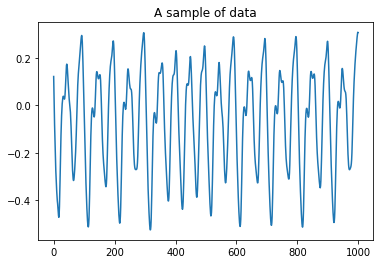

In [ ]:
import matplotlib.pyplot as plt
from scipy import linalg
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys
# numpy.linalg is also an option for even fewer dependencies

# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/MackeyGlass_t17.txt')
data = torch.from_numpy(data)
print(data.shape)

# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')
# sys.exit()

# generate the ESN reservoir
inSize = 1
outSize = 1
resSize = 1000
a = 0.3 # leaking rate, reservoir 뉴런 값 수정률
Win = nn.Parameter(torch.rand(resSize,1+inSize,requires_grad=False) - 0.5) # (1000, 2) 행렬 생성 -> (reservoir수, 인풋차원+1) -> +1 : bias 공간
W = nn.Parameter(torch.rand(resSize,resSize, requires_grad=False) - 0.5) # (1000, 1000) 초기 가중치 행렬 생성(랜덤) -> (reservoir수, reservoir수) : reservoir 뉴런의 학습 가중치 행렬

# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
# rhoW = spectral radius
rhoW = torch.max(torch.abs(torch.linalg.eig(W)[0])) # 가중치 행렬에서 고유값 추출 (각 뉴런 업데이트시 W에 곱해지는 강도(spectral radius)), W 행렬 1개당 1개 값 생성됌
# reservoir 뉴런 개수인 resSize 가 90이라면 90 * 90 차원의 랜덤 행렬 생성후 고유값은 90개가 나옴.
print('done.')
# 가중치 업데이트 과정 -> 각 고유값을 weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
W = W * (1.25 / rhoW)
# W *= 1.25 / rhoW

# allocated memory for the design (collected states) matrix - state matrix - reservoir 셀 값
# X의 형태에서 row인 1002는 1회 학습시 업데이트될 인풋값(1회 학습하여 업데이트 된 X값은 세로방향으로 들어옴), 1900 col은 기록할 학습 횟수(총 학습 횟수 - 최소초기학습횟수) 
X = torch.zeros(1+inSize+resSize,trainLen-initLen) # (1002, 1900) 학습 데이터 행렬 초기 정의
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]  # (1, 1900) -> 예측 데이터는 101번부터 2001번 index, Yt는 Y truth로 실제값

# run the reservoir with the data and collect X
x = torch.zeros(resSize,1) # (1000,1) , reservoir 뉴런이 갖고있는 값
print(data[5])
for t in range(trainLen): # train data 2000개만큼 돌면서(reservoir 뉴런의 학습 횟수)
    u = data[t] # u에 t번째 데이터 할당 
    # print(np.dot(Win, np.vstack((1,u))).shape) # (1000,2) 내적 (2,1) -> (1000,1) -> 인풋뉴런에 인풋 데이터 주입
    # print("###")
    # print(np.dot(W,x).shape) # (1000,1000) 내적 (1000,1) -> (1000,1) -> 뉴런 내부값에 가중치 매트릭스 곱해서 업데이트
    # print("###")

    # vstack : 위아래 결합 - dim=0, hstack : 좌우결합 - dim=1
    # reservoir 뉴런 내부값 업데이트 과정, 활성함수 tanh사용
    print(Win.shape)
    uten = torch.Tensor([u])
    print(uten.shape)
    tttt = torch.Tensor([1])
    print(tttt.shape)
    print(torch.cat([tttt,uten], dim=0))
    # print(torch.cat((1,u), dim=0))
    # sys.exit()
    x = (1-a)*x + a*torch.tanh( torch.matmul( Win, torch.cat([1,u], dim=0)) + torch.matmul( W, x ) ) # (1000,1) # vstack
    # print(np.vstack((1,u,x)).shape) # (1002,1) 세로로된 리스트
    # print(np.vstack((1,u,x))[:,0].shape) # (1002,) 가로로된 리스트
    
    # 학습횟수(2000번) 중에 최소초기학습횟수 넘어갈 때부터 학습데이터도 업데이트
    if t >= initLen: # 최소초기학습횟수 넘어갈때부터 학습 데이터 업데이트(최소초기학습 횟수 이전까지는 reservoir 뉴런값, Weight matrix만 업데이트)
        X[:,t-initLen] = torch.cat([1,u,x], dim=0)[:,0]


# print(torch.dot(X, X.T).shape) # (1002,1002) -> 업데이트된 인풋행렬(X) 에서 각 요소 제곱하여 음수값 제거
# print(torch.eye(1+inSize+resSize)) # (1002,1002) 의 대각행렬 생성(대각선만 1, 나머지 0) ->  행렬곱 진행 시 regularization 진행을 위한 행렬
# print((torch.dot(X,X.T) + torch.eye(1+inSize+resSize)).shape) # (1002,1002) -> 제곱하여 음수값 제거한 인풋 행렬에 규제수치 곱해줌 -> 규제화한 예측값 행렬
# print(torch.dot(X,Yt.T).shape) # (1002,1) -> 업데이트된 인풋 행렬(X, (1002,1900))과 예측값행렬(Yt.T(1900,1)) 의 내적 -> 학습 횟수당 실제값 행렬(ground truth)

# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
# 연립방정식에서 규제화한 예측값 행렬을 계수로 사용하고 학습 횟수당 실제값행렬을 실제값으로 사용하여 연립방정식의 해를 구함
# 이때, 연립방정식의 해는 예측값에서 얼만큼의 가중치를 곱해줘야 실제값이 나오는지에서 가중치의 값을 의미함.
Wout = torch.linalg.solve( torch.matmul(X,X.T) + reg*torch.eye(1+inSize+resSize), torch.matmul(X,Yt.T) ).T # (1,1002)


# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = torch.zeros(outSize,testLen) # (1,2000)
u = data[trainLen] # 학습에 사용한 데이터셋의 마지막 인덱스의 값
print(u)
# sys.exit() # debugging 용도로 사용한 코드
for t in range(testLen): # 테스트 사이즈 2000번 돌면서
    x = (1-a)*x + a*torch.tanh( torch.matmul( Win, torch.cat([1,u], dim=0)) + torch.matmul( W, x ) ) # 학습된 reservoir 뉴런들의 가중치
    y = torch.matmul( Wout, torch.cat([1,u,x], dim=0) ) # (1,1002) 내적 (1002,1) -> 출력층으로 가는 weight값과 학습된 reservoir들의 가중치 내적(연결) -> 예측값 도출
    Y[:,t] = y # 테스트셋의 인덱스 때마다 나온 결과 입력
    # generative mode: # 테스트 모드
    u = y # 예측값을 다음 테스트의 인풋으로 넣음
    ## this would be a predictive mode: # 예측 모드 -> 둘중 하나 아무거나 사용해도 무방해보임
    #u = data[trainLen+t+1] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( torch.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))
    
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( torch.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()